# famCHESS EDA

Kendra Wyant

## Notes

This script reads in the cleaned famCHESS data and performs EDA on final variables.

## Setup

In [ ]:
options(conflicts.policy = "depends.ok")
suppressMessages(library(tidyverse))
suppressMessages(library(janitor))
library(Matrix, exclude = c("expand", "pack", "unpack"))
library(lme4)
theme_set(theme_classic()) 

devtools::source_url("https://github.com/jjcurtin/lab_support/blob/main/format_path.R?raw=true")


ℹ SHA-1 hash of file is "a58e57da996d1b70bb9a5b58241325d6fd78890f"

## Data

### Cleaning

In [ ]:
data <- haven::read_sav(here::here(path_data, "Famchess_clean_combined_FINAL.sav")) |> 
  clean_names() 

dsm <- haven::read_sav(here::here(path_data, "FamCHESS_DSM5.sav")) |> 
  clean_names() # for stratification check


Remove participants with inaccurate data (from Olivia’s script):

-   167PT (baseline and 4 month): FAM passed away after baseline
-   208FAM & 208PT (noted on all timepoints): Might be wholly unreliable since we suspect he is his own partner
-   365PT (noted on 1 timepoint): Answered relationship questions about her dog, not her son
-   365FAM (noted on 1 timepoint): Answered relationship questions about romantic partner, not his mom

In [ ]:
data <- data |> 
  filter(!study_id %in% c("167PT", "208FAM", "208PT", "365PT", "365FAM"))


Recode variables (from Olivia’s script)

195PT: reported prefer not to say for gender on baseline but reported male in TLFB data. Changing to male to match TLFB.

In [ ]:
data <- data |> 
  mutate(gender = if_else(study_id == "195PT", 2, gender))


Gender - 2 levels (male / non-male) - TLFB is also coded this way

-   500PT: non-binary
-   128FAM: Transgender women

*KW: currently setting these two people to Non-male, however, I saw this in scales/measures doc - not enough non-man/ women responses to have 3rd level. For patients, those who don’t fall into groups set to missing*

In [ ]:
data <- data |> 
  mutate(gender_original = gender, 
         gender = if_else(gender != 2, 1, gender),
         gender = sjlabelled::set_labels(gender, labels = c("Non-male", "Male"))) 

tabyl(data$gender_original)


 data$gender_original   n     percent valid_percent
                    1 775 0.567765568   0.569434240
                    2 580 0.424908425   0.426157237
                    3   2 0.001465201   0.001469508
                    5   4 0.002930403   0.002939015
                   NA   4 0.002930403            NA

 data$gender   n     percent valid_percent
           1 781 0.572161172     0.5738428
           2 580 0.424908425     0.4261572
          NA   4 0.002930403            NA

Create binary covariate for race/ethnicity defined as: White only (non-Hispanic) vs. not White only

In [ ]:
data <- data |> 
  mutate(race_white_only = if_else(ethnicity == 0 & race_1 == 1 &
                                     race_2 == 0 & race_3 == 0 &
                                     race_4 == 0 & race_5 == 0 &
                                     race_6 == 0, 1, 0))

tabyl(data$race_white_only)


 data$race_white_only    n     percent valid_percent
                    0  335 0.245421245     0.2461425
                    1 1026 0.751648352     0.7538575
                   NA    4 0.002930403            NA

Center non-binary covariates: age and edu

In [ ]:
data <- data |> 
  mutate(age_c = age - mean(age, na.rm = TRUE))


*KW: education is not continuous. Is centering best transformation? Maybe instead pick a certain level? Centering on mean for now*

In [ ]:
sjlabelled::get_labels(data$edu)


[1] "8th grade or less"                     
[2] "Some high school, but did not graduate"
[3] "High school graduate or GED"           
[4] "Some college or 2 year degree"         
[5] "4-year college graduate"               
[6] "More than 4-year college degree"       

[1] 4.274798

 data$edu   n     percent valid_percent
        1   8 0.005860806   0.005878031
        2  42 0.030769231   0.030859662
        3 266 0.194871795   0.195444526
        4 510 0.373626374   0.374724467
        5 322 0.235897436   0.236590742
        6 213 0.156043956   0.156502572
       NA   4 0.002930403            NA

Recode data to have baseline scores of outcomes as covariate

*KW: 36 study ids provided baseline info but no data at later time points*

In [ ]:
baseline_values <- data |>  
  filter(time == 0) |> 
  select(study_id, 
         hdd_0 = per_heavy_drink_days, 
         pda_0 = per_days_abstinent, 
         oq45_0 = oq45_scored, 
         relationsatisf_0 = relationsatisf_scored, 
         abuse_0 = abuse_scored)

baseline_values |> 
  filter(!study_id %in% subset(data, time != 0)$study_id) |> 
  print(n = Inf)


# A tibble: 36 × 6
   study_id hdd_0 pda_0 oq45_0 relationsatisf_0 abuse_0
   <chr>    <dbl> <dbl>  <dbl>            <dbl>   <dbl>
 1 110PT    100     0       25               25      NA
 2 111PT     30.6  44.6     50               26      NA
 3 117FAM    NA    NA       32               18      NA
 4 119FAM    NA    NA       29               27       3
 5 119PT     98.3   0.8     64               25      NA
 6 121PT     33.9  66.1     68               31      26
 7 125PT     26.4  73.6     74               21      NA
 8 130FAM    NA    NA       94               23       7
 9 130PT     99.2   0.8    109               25       2
10 139PT      9.2  90.8     80               21      NA
11 140FAM    NA    NA       61               20      NA
12 148FAM    NA    NA       70               17       4
13 148PT     99.2   0.8     74               18       2
14 149PT     75    23.3     30               25      NA
15 155FAM    NA    NA       35               17       2
16 155PT     NA    NA       7

In [ ]:
data <- data |> 
  filter(time != 0) |> 
  full_join(baseline_values, by = "study_id")


*KW: confirm this is okay with John - remove 36 individuals with only baseline data*

*KW: Remove partners too?*

In [ ]:
dyad_ids <- baseline_values |> 
  mutate(dyad_id = str_sub(study_id, 1, 3)) |> 
  filter(!study_id %in% subset(data, time != 0)$study_id) |> 
  pull(dyad_id) |> 
  unique()
  
data |> 
  mutate(dyad_id = str_sub(study_id, 1, 3)) |> 
  filter(dyad_id %in% dyad_ids) |> 
  select(study_id, dyad_id) |> 
  unique() |> 
  arrange(dyad_id) |> 
  print(n = Inf)


# A tibble: 53 × 2
   study_id dyad_id
   <chr>    <chr>  
 1 110FAM   110    
 2 110PT    110    
 3 111FAM   111    
 4 111PT    111    
 5 117PT    117    
 6 117FAM   117    
 7 119FAM   119    
 8 119PT    119    
 9 121FAM   121    
10 121PT    121    
11 125FAM   125    
12 125PT    125    
13 130FAM   130    
14 130PT    130    
15 139FAM   139    
16 139PT    139    
17 140PT    140    
18 140FAM   140    
19 148FAM   148    
20 148PT    148    
21 149FAM   149    
22 149PT    149    
23 155FAM   155    
24 155PT    155    
25 156PT    156    
26 156FAM   156    
27 167FAM   167    
28 181FAM   181    
29 181PT    181    
30 190FAM   190    
31 190PT    190    
32 198FAM   198    
33 198PT    198    
34 199FAM   199    
35 199PT    199    
36 203FAM   203    
37 203PT    203    
38 205FAM   205    
39 205PT    205    
40 209FAM   209    
41 209PT    209    
42 303FAM   303    
43 303PT    303    
44 314FAM   314    
45 314PT    314    
46 315PT    315    
47 315FAM   315    
4

Center baseline values of outcomes

In [ ]:
data <- data |> 
  mutate(hdd_0 = hdd_0 - mean(hdd_0, na.rm = TRUE),
         pda_0 = pda_0 - mean(pda_0, na.rm = TRUE),
         oq45_0 = oq45_0 - mean(oq45_0, na.rm = TRUE),
         relationsatisf_0 = relationsatisf_0 - mean(relationsatisf_0, na.rm = TRUE),
         abuse_0 = abuse_0 - mean(abuse_0, na.rm = TRUE))


Center time at the end of the intervention period (8 months).

In [ ]:
sjlabelled::get_labels(data$time)


[1] "Baseline" "4 Month"  "8 Month"  "12 Month"

 data$time   n   percent
         1 328 0.3534483
         2 315 0.3394397
         3 285 0.3071121

### EDA

Remove vars not used in analyses (e.g., keep scale score and remove individual items).

*KW: COVID acute/residual symptoms was originally listed as covariate but was removed per measures doc (Participants interpreted question differently).*

*KW: phq, promis, loneliness, coping, interaction scales not scored or in measures doc. Removed from analyses data set.*

In [ ]:
data <- data |> 
  select(-c(treatmentskills_1:treatmentskills_18_recode,
            oq45_1:oq45_45, alcoholproblems_1:alcoholproblems_15, 
            relationsatisf_1:relationsatisf_8, phq_1:phq_8, 
            abuse_1:abuse_16_yes, promis29_1:promis29_8, 
            abuse_physical_scored:abuse_psychological_scored, gender_open,
            loneliness_1:loneliness_8, healthservice_1, healthservice_2,
            healthservice_3,healthservice_4,healthservice_5, 
            healthservice_5a_1:healthservice_5c, 
            healthservice_6a_1:healthservice_8a, healthservice_8b, 
            healthservice_9a, healthservice_9b, bonding_1:bonding_5, 
            socrates_1:socrates_20, coping_1:coping_25, 
            drinkinggoals:drinkinggoal_7_text, covid_1:covid_3f,
            interaction_1:interaction_20, drink_druguse_1:drinkdruguse_8d,
            employmentstatus:notemployed_open, ethnicity:race_open, 
            livewith_1:livewith_open, er_yn, outpatient_yn, 
            inpatient_yn, n_days, mean_drinks_per_day, per_drink_days, 
            covid_scored,redcap_event_name, recruitment_id)) |> 
  rename(other_medications_yn = healthservice_6,
         readmits_yn = r_eadmits_yn) |>  # renaming for descriptive/consistency
  relocate(study_id) |> 
  glimpse()


Rows: 928
Columns: 44
$ study_id                    <chr> "100FAM", "100FAM", "100FAM", "100PT", "10…
$ dyad                        <dbl+lbl> 1, 1, 1, 2, 2, 2, 1, 1, 1, 2, 2, 2, 1,…
$ arm                         <dbl+lbl> 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 2,…
$ group                       <dbl+lbl> 4, 4, 4, 1, 1, 1, 3, 3, 3, 0, 0, 0, 5,…
$ time_string                 <chr> "4 Month", "8 Month", "12 Month", "12 Mont…
$ time                        <dbl+lbl> 1, 2, 3, 3, 1, 2, 1, 2, 3, 1, 2, 3, 1,…
$ comments                    <chr> "", "", "", "", "", "", "", "", "", "", ""…
$ gender                      <dbl+lbl> 1, 1, 1, 2, 2, 2, 1, 1, 1, 2, 2, 2, 1,…
$ age                         <dbl> 55, 55, 55, 56, 56, 56, 62, 62, 62, 66, 66…
$ edu                         <dbl+lbl> 4, 4, 4, 3, 3, 3, 4, 4, 4, 3, 3, 3, 6,…
$ income                      <dbl+lbl> 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4,…
$ partner_relationship        <dbl+lbl> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 5,…
$ employment      

Number of participants

In [ ]:
data |> 
  pull(study_id) |>
  unique() |> 
  length() # 340


[1] 340

[1] 170

[1] 170

Complete dyad (patient + partner) for all participants

In [ ]:
data |> 
  select(study_id) |> 
  unique() |> 
  mutate(dyad_id = str_sub(study_id, 1, 3)) |> 
  group_by(dyad_id) |> 
  count() |> 
  filter(n != 2)


# A tibble: 0 × 2
# Groups:   dyad_id [0]
# ℹ 2 variables: dyad_id <chr>, n <int>

Missing data

In [ ]:
data |> 
  naniar::miss_var_summary() |> 
  print(n = Inf)


# A tibble: 44 × 3
   variable                    n_miss pct_miss
   <chr>                        <int>    <num>
 1 readmits_yn                    903   97.3  
 2 abuse_scored                   680   73.3  
 3 abuse_0                        538   58.0  
 4 per_days_abstinent             498   53.7  
 5 per_heavy_drink_days           498   53.7  
 6 socrates_scored                493   53.1  
 7 socrates_recognition_scored    493   53.1  
 8 socrates_ambivalence_scored    493   53.1  
 9 treatmentskills_scored         479   51.6  
10 hdd_0                          464   50    
11 pda_0                          464   50    
12 days_app_use                   455   49.0  
13 other_medications_yn            42    4.53 
14 mat_yn                          39    4.20 
15 peersupport_scored              39    4.20 
16 meetings_yn                     36    3.88 
17 other_psych_treatment_yn        36    3.88 
18 relationship_status             35    3.77 
19 oq45_scored                     35    

Missing data for just patients

-   treatmentskills not applicable to patients
-   abuse and readmits have high missing data
-   Why days_app_use missing so high?

In [ ]:
data |> 
  filter(dyad == 2) |> 
  naniar::miss_var_summary() |> 
  print(n = Inf)


# A tibble: 44 × 3
   variable                    n_miss pct_miss
   <chr>                        <int>    <num>
 1 treatmentskills_scored         464  100    
 2 readmits_yn                    440   94.8  
 3 abuse_scored                   370   79.7  
 4 abuse_0                        291   62.7  
 5 days_app_use                   151   32.5  
 6 per_days_abstinent              34    7.33 
 7 per_heavy_drink_days            34    7.33 
 8 other_medications_yn            30    6.47 
 9 mat_yn                          29    6.25 
10 socrates_scored                 29    6.25 
11 socrates_recognition_scored     29    6.25 
12 socrates_ambivalence_scored     29    6.25 
13 peersupport_scored              28    6.03 
14 meetings_yn                     26    5.60 
15 other_psych_treatment_yn        26    5.60 
16 relationship_status             25    5.39 
17 oq45_scored                     25    5.39 
18 relationsatisf_scored           25    5.39 
19 income                          12    

Remove `readmits_yn` as covariate due to low endorsement

*KW: not sure why so many NAs*

In [ ]:
sjlabelled::get_labels(data$readmits_yn)


[1] "No"  "Yes"

Missing data for partners

In [ ]:
data |> 
  filter(dyad == 1) |> 
  naniar::miss_var_summary() |> 
  print(n = Inf)


# A tibble: 43 × 3
   variable                    n_miss pct_miss
   <chr>                        <int>    <num>
 1 per_days_abstinent             464  100    
 2 per_heavy_drink_days           464  100    
 3 socrates_scored                464  100    
 4 socrates_recognition_scored    464  100    
 5 socrates_ambivalence_scored    464  100    
 6 hdd_0                          464  100    
 7 pda_0                          464  100    
 8 abuse_scored                   310   66.8  
 9 days_app_use                   304   65.5  
10 abuse_0                        247   53.2  
11 treatmentskills_scored          15    3.23 
12 other_medications_yn            12    2.59 
13 peersupport_scored              11    2.37 
14 meetings_yn                     10    2.16 
15 other_psych_treatment_yn        10    2.16 
16 mat_yn                          10    2.16 
17 relationship_status             10    2.16 
18 oq45_scored                     10    2.16 
19 relationsatisf_scored           10    

Participants in each arm

In [ ]:
data |> 
  group_by(study_id) |> 
  slice(1) |> 
  tabyl(arm)


 arm   n   percent
   0 108 0.3176471
   1 118 0.3470588
   2 114 0.3352941

Check stratification variables in arms - patient gender identity and alcohol use severity (moderate or severe AUD)

DSM5 criteria: 1 = severe, 2 = moderate, 3 = mild  
Group: 0 = patient control, 1 = patient achess, 2 = patient famchess,

In [ ]:
data |> 
  filter(dyad == 2) |> 
  group_by(study_id) |> 
  slice(1) |> 
  tabyl(group, gender)


 group  1  2 NA_
     0 22 31   1
     1 26 33   0
     2 23 34   0

 group  1 2 3 NA_
     0 51 1 1   1
     1 58 1 0   0
     2 50 6 1   0

Demographic and study related variables

Time string matches time

In [ ]:
data |> 
  tabyl(time, time_string)


 time 12 Month 4 Month 8 Month
    1        0     328       0
    2        0       0     315
    3      285       0       0

*KW: discuss with John if we need to do anything with these notes*

In [ ]:
data |> 
  filter(!comments == "") |> 
  pull(comments)


 [1] "Missing TLFB"                                                                                                                                                                                       
 [2] "Missing TLFB"                                                                                                                                                                                       
 [3] "Missing survey data"                                                                                                                                                                                
 [4] "Missing TLFB"                                                                                                                                                                                       
 [5] "Missing TLFB"                                                                                                                                                                         

Income

In [ ]:
sjlabelled::get_labels(data$income)


[1] "Less than $25,000"    "$25,000 to $34,999"   "$35,000 to $49,999"  
[4] "$50,000 to $74,999"   "$75,000 to $99,999"   "$100,000 to $149,999"
[7] "$150,000 to $199,999" "$200,000 or more"    

 data$income   n    percent valid_percent
           1 177 0.19073276    0.19386637
           2  57 0.06142241    0.06243154
           3  91 0.09806034    0.09967141
           4 192 0.20689655    0.21029573
           5 160 0.17241379    0.17524644
           6 144 0.15517241    0.15772180
           7  65 0.07004310    0.07119387
           8  27 0.02909483    0.02957284
          NA  15 0.01616379            NA

Partner relationship

In [ ]:
sjlabelled::get_labels(data$partner_relationship)


[1] "Romantic partner/spouse" "Parent"                 
[3] "Adult child"             "Other family member"    
[5] "Friend"                  "Recovery Coach"         

 data$partner_relationship   n     percent valid_percent
                         1 614 0.661637931   0.663783784
                         2  74 0.079741379   0.080000000
                         3  73 0.078663793   0.078918919
                         4  98 0.105603448   0.105945946
                         5  63 0.067887931   0.068108108
                         6   3 0.003232759   0.003243243
                        NA   3 0.003232759            NA

Employment

In [ ]:
sjlabelled::get_labels(data$employment)


[1] "No"  "Yes"

 data$employment   n     percent valid_percent
               0 315 0.339439655     0.3405405
               1 610 0.657327586     0.6594595
              NA   3 0.003232759            NA

Relationship status with partner

In [ ]:
sjlabelled::get_labels(data$relationship_status)


[1] "Still together (e.g., as a romantic couple, as family, as friends)"
[2] "Split up but still working on this project together"               
[3] "Split up and not working on this project together"                 
[4] "Other"                                                             

 data$relationship_status   n    percent valid_percent
                        1 762 0.82112069    0.85330347
                        2  62 0.06681034    0.06942889
                        3  24 0.02586207    0.02687570
                        4  45 0.04849138    0.05039194
                       NA  35 0.03771552            NA

 [1] "Still friends but he is unsure how much if at all she is using the app"                                                                         
 [2] "parent"                                                                                                                                         
 [3] "None"                                                                                                                                           
 [4] "None"                                                                                                                                           
 [5] "Not seeing"                                                                                                                                     
 [6] "Little contact"                                                                                                                                 
 [7] "work schedules collide"                                                                 

univariate descriptives of covariates, mediators, moderators and outcome variables

In [ ]:
data |> 
  select(age, edu, days_app_use:abuse_0, -gender_original, -age_c, 
         -relationship_status, - relationship_status_open) |> 
  skimr::skim()


  ----------------------------------------------------------------------------------------------------------------------------
  skim_variable                   n_missing   complete_rate    mean      sd       p0      p25     p50     p75     p100 hist
  ----------------------------- ----------- --------------- ------- ------- -------- -------- ------- ------- -------- -------
  age                                     6            0.99   47.62   13.59    21.00    37.00   47.50   58.00    89.00 ▅▇▇▃▁

  edu                                     3            1.00    4.28    1.08     1.00     4.00    4.00    5.00     6.00 ▁▅▇▅▃

  days_app_use                          455            0.51   41.14   38.05     0.00     6.00   32.00   74.00   161.00 ▇▃▃▂▁

  per_days_abstinent                    498            0.46   60.96   37.45     0.00    29.98   71.05   98.20   100.00 ▅▂▂▃▇

  per_heavy_drink_days                  498            0.46   24.20   33.27     0.00     0.00    5.65   34.35   100.00 ▇▂▁▁▂

  meetings_yn                            36            0.96    0.18    0.38     0.00     0.00    0.00    0.00     1.00 ▇▁▁▁▂

  outpatient_yn_ever                      0            1.00    0.18    0.39     0.00     0.00    0.00    0.00     1.00 ▇▁▁▁▂

  other_psych_treatment_yn               36            0.96    0.16    0.37     0.00     0.00    0.00    0.00     1.00 ▇▁▁▁▂

  er_yn_ever                              0            1.00    0.22    0.41     0.00     0.00    0.00    0.00     1.00 ▇▁▁▁▂

  mat_yn                                 39            0.96    0.10    0.30     0.00     0.00    0.00    0.00     1.00 ▇▁▁▁▁

  other_medications_yn                   42            0.95    0.35    0.48     0.00     0.00    0.00    1.00     1.00 ▇▁▁▁▅

  inpatient_yn_ever                       0            1.00    0.10    0.30     0.00     0.00    0.00    0.00     1.00 ▇▁▁▁▁

  oq45_scored                            35            0.96   55.33   25.33     0.00    37.00   54.00   71.00   140.00 ▃▇▆▂▁

  relationsatisf_scored                  35            0.96   21.64    6.40     0.00    18.00   22.00   26.00    36.00 ▁▂▆▇▃

  abuse_scored                          680            0.27    4.40    7.35     0.00     1.00    2.00    6.00    72.00 ▇▁▁▁▁

  treatmentskills_scored                479            0.48    3.11    0.51     1.00     2.83    3.13    3.47     4.00 ▁▁▃▇▅

  peersupport_scored                     39            0.96    2.92    1.17     1.00     2.00    2.80    3.80     5.00 ▆▇▇▅▅

  socrates_scored                       493            0.47   32.36    7.06    10.00    28.00   33.00   39.00    40.00 ▁▁▃▅▇

  socrates_recognition_scored           493            0.47   25.84    6.70     7.00    22.00   26.00   31.00    35.00 ▁▂▆▇▇

  socrates_ambivalence_scored           493            0.47   13.48    4.25     4.00    11.00   14.00   17.00    20.00 ▂▃▅▇▆

  race_white_only                         3            1.00    0.76    0.43     0.00     1.00    1.00    1.00     1.00 ▂▁▁▁▇

  edu_c                                   3            1.00    0.01    1.08    -3.27    -0.27   -0.27    0.73     1.73 ▁▅▇▅▃

  hdd_0                                 464            0.50    0.00   36.11   -49.00   -32.70   -6.90   39.70    51.00 ▇▆▃▃▇

  pda_0                                 464            0.50    0.00   33.84   -37.48   -35.81   -4.18   30.32    62.52 ▇▂▂▃▂

  oq45_0                                  3            1.00    0.00   24.41   -55.71   -18.71   -1.71   15.29    73.29 ▂▇▇▃▁

  relationsatisf_0                        3            1.00    0.00    5.01   -18.52    -2.52    0.48    3.48    12.48 ▁▂▇▇▂

  abuse_0                               538            0.42    0.00    4.55    -4.45    -3.45   -1.45    2.30    19.55 ▇▃▁▁▁
  ----------------------------------------------------------------------------------------------------------------------------


Bivariate correlations for Patient

*KW: simplify?*

In [ ]:
data |> 
  filter(dyad == 2) |> 
  select(age, edu, days_app_use:abuse_0, -gender_original, -age_c,
         -treatmentskills_scored, -relationship_status, 
         -relationship_status_open) |> 
  cor(use = "pairwise.complete.obs") |> 
  round(2)


                              age   edu days_app_use per_days_abstinent
age                          1.00  0.04         0.21              -0.16
edu                          0.04  1.00        -0.01               0.00
days_app_use                 0.21 -0.01         1.00               0.02
per_days_abstinent          -0.16  0.00         0.02               1.00
per_heavy_drink_days         0.03 -0.13        -0.14              -0.75
meetings_yn                 -0.17 -0.07        -0.03               0.21
outpatient_yn_ever          -0.25 -0.05        -0.19               0.18
other_psych_treatment_yn    -0.04  0.03         0.04               0.09
er_yn_ever                  -0.01 -0.22        -0.01               0.06
mat_yn                      -0.10 -0.02        -0.05               0.02
other_medications_yn         0.08  0.21        -0.13               0.00
inpatient_yn_ever           -0.18 -0.03        -0.19               0.15
oq45_scored                 -0.13 -0.15        -0.13            

### Check Assumptions for Analyses of Study Arm Effects

patient primary outcome = `per_heavy_drink_days`  
partner primary outcome = `oq45_scored`

patient secondary outcome = `per_days_abstinent`  
partner secondary outcomes = `relationsatisf_scored` and `abuse_scored`

*KW: Cannot run primary and secondary patient models for partners (outcomes don’t exist). We could run primary and secondary partner models for patients, but why would we want to do this?*

List of potential covariate variable names: `race_white_only`, `age_c`, `edu_c`, `meetings_yn`, `outpatient_yn_ever`, `er_yn_ever`, `mat_yn`, `inpatient_yn_ever`, `other_psych_treatment_yn`, `other_medications_yn`

Set contrasts

In [ ]:
col_names <- c("fam_and_achess_vs_C", "achess_vs_fam")
arm_contrasts <- matrix(c(-2/3, 1/3, 1/3, 0, 1/2, -1/2),
                          nrow = 3, ncol = 2,
                          dimnames = list(levels(data$arm), col_names))

data <- data |> 
  mutate(arm_c = as.factor(arm))

contrasts(data$arm_c) <- arm_contrasts
contrasts(data$arm_c)


  fam_and_achess_vs_C achess_vs_fam
0          -0.6666667           0.0
1           0.3333333           0.5
2           0.3333333          -0.5

#### Primary Patient Outcome: `per_heavy_drink_days`

##### Check distribution of residuals

*KW: seems normal enough?*

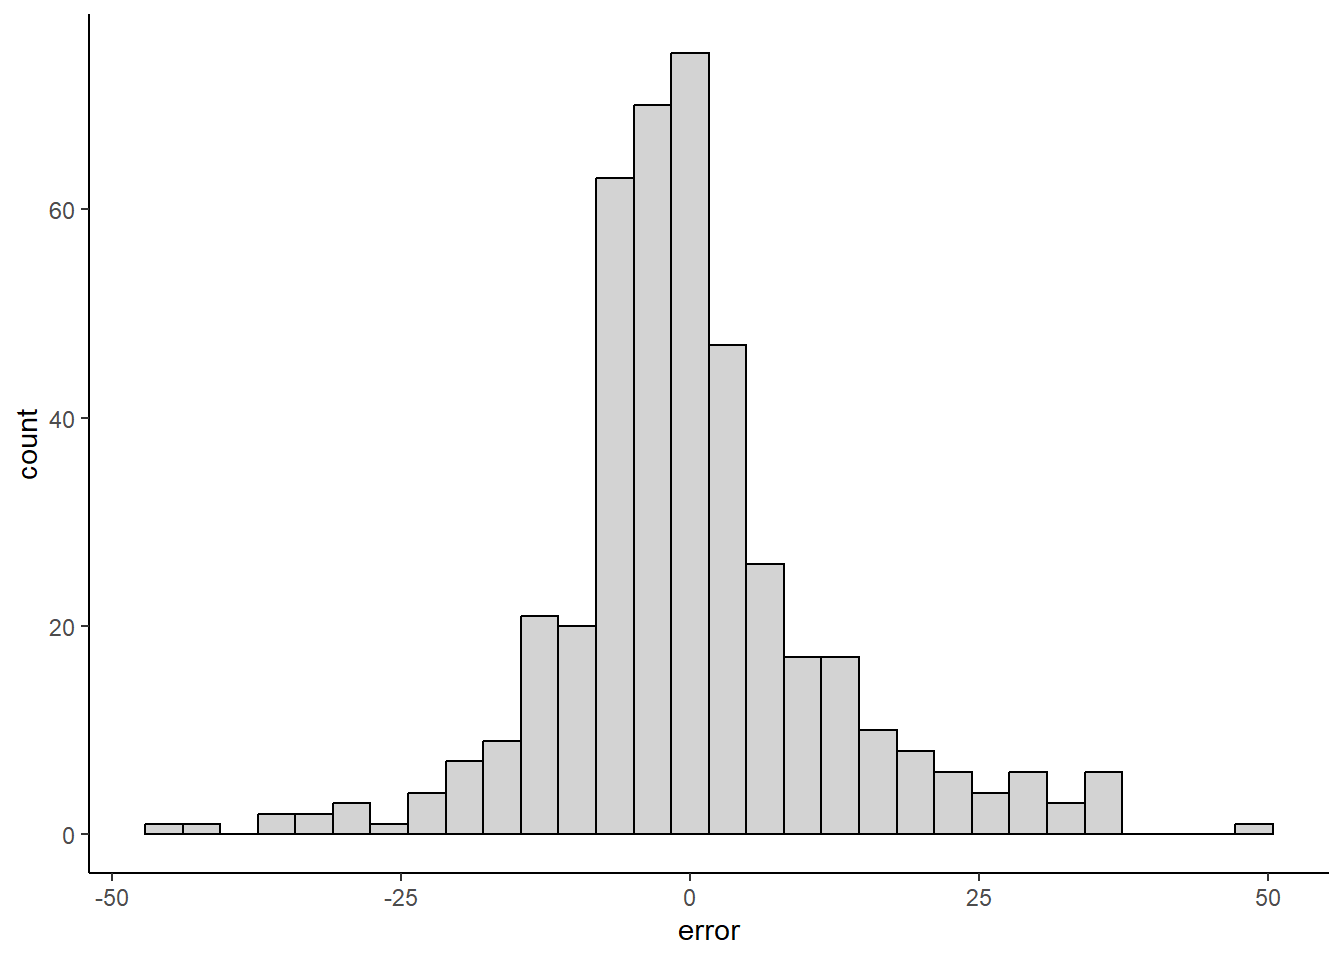

In [ ]:
model_patient_prim <- lmer(per_heavy_drink_days ~ time_c*arm_c + hdd_0 + 
                             (1 + time_c | study_id), data = subset(data, dyad == 2))

tibble(error = residuals(model_patient_prim)) |> 
  ggplot(aes(x = error)) +
  geom_histogram(color = "black", fill = "light grey", bins = 30)


##### Look for significant covariates (We will only include covariates that significantly predict the outcome).

`race_white_only` - not significant

In [ ]:
model_patient_prim_race <- lmer(per_heavy_drink_days ~ time_c*arm_c + hdd_0 + 
                                  race_white_only + (1 + time_c | study_id), 
                                data = subset(data, dyad == 2))

sjPlot::tab_model(model_patient_prim_race, show.re.var = F, show.icc = F, terms = c("race_white_only"))


Percent of days with heavy drinking 
 
 
 Predictors 
 Estimates 
 CI 
 p 
 
 
 race white only 
 -0.26 
 -8.95 – 8.43 
 0.953 
 

 
 N study_id 
 157 
 
 Observations 
 427 
 
 
 Marginal R 2 / Conditional R 2 
 0.282 / 0.765

`age_c` - not significant

In [ ]:
model_patient_prim_age <- lmer(per_heavy_drink_days ~ time_c*arm_c + hdd_0 + 
                                  age_c + (1 + time_c | study_id), 
                                data = subset(data, dyad == 2))

sjPlot::tab_model(model_patient_prim_age, show.re.var = F, show.icc = F, terms = c("age_c"))


Percent of days with heavy drinking 
 
 
 Predictors 
 Estimates 
 CI 
 p 
 
 
 2.What is your age? 
 0.12 
 -0.18 – 0.42 
 0.422 
 

 
 N study_id 
 156 
 
 Observations 
 424 
 
 
 Marginal R 2 / Conditional R 2 
 0.285 / 0.761

`edu_c` - not significant

In [ ]:
model_patient_prim_edu <- lmer(per_heavy_drink_days ~ time_c*arm_c + hdd_0 + 
                                  edu_c + (1 + time_c | study_id), 
                                data = subset(data, dyad == 2))

sjPlot::tab_model(model_patient_prim_edu, show.re.var = F, show.icc = F, terms = c("edu_c"))


Percent of days with heavy drinking 
 
 
 Predictors 
 Estimates 
 CI 
 p 
 
 
 edu c 
 -0.46 
 -4.08 – 3.16 
 0.803 
 

 
 N study_id 
 157 
 
 Observations 
 427 
 
 
 Marginal R 2 / Conditional R 2 
 0.283 / 0.765

`meetings_yn` - not significant

In [ ]:
model_patient_prim_meetings <- lmer(per_heavy_drink_days ~ time_c*arm_c + hdd_0 + 
                                  meetings_yn + (1 + time_c | study_id), 
                                data = subset(data, dyad == 2))

sjPlot::tab_model(model_patient_prim_meetings, show.re.var = F, show.icc = F, terms = c("meetings_yn"))


Percent of days with heavy drinking 
 
 
 Predictors 
 Estimates 
 CI 
 p 
 
 
 meetings yn 
 -6.54 
 -13.30 – 0.22 
 0.058 
 

 
 N study_id 
 158 
 
 Observations 
 413 
 
 
 Marginal R 2 / Conditional R 2 
 0.267 / 0.749

`outpatient_yn_ever` - not significant

In [ ]:
model_patient_prim_outpatient <- lmer(per_heavy_drink_days ~ time_c*arm_c + hdd_0 + 
                                  outpatient_yn_ever + (1 + time_c | study_id), 
                                data = subset(data, dyad == 2))

sjPlot::tab_model(model_patient_prim_outpatient, show.re.var = F, show.icc = F, terms = c("outpatient_yn_ever"))


Percent of days with heavy drinking 
 
 
 Predictors 
 Estimates 
 CI 
 p 
 
 
 Did they have atleast one outpatient treatment for alcohol or drug use within the surveyed peirod? 
 -7.44 
 -15.72 – 0.84 
 0.078 
 

 
 N study_id 
 158 
 
 Observations 
 430 
 
 
 Marginal R 2 / Conditional R 2 
 0.284 / 0.764

`er_yn_ever` - **significant**

In [ ]:
model_patient_prim_er <- lmer(per_heavy_drink_days ~ time_c*arm_c + hdd_0 + 
                                er_yn_ever + (1 + time_c | study_id), 
                                data = subset(data, dyad == 2))

sjPlot::tab_model(model_patient_prim_er, show.re.var = F, show.icc = F, terms = c("er_yn_ever"))


Percent of days with heavy drinking 
 
 
 Predictors 
 Estimates 
 CI 
 p 
 
 
 Did they have atleast one ER visit within the surveyed peirod? 
 -10.40 
 -18.85 – -1.95 
 0.016 
 

 
 N study_id 
 158 
 
 Observations 
 430 
 
 
 Marginal R 2 / Conditional R 2 
 0.284 / 0.761

`mat_yn` - not significant

In [ ]:
model_patient_prim_mat <- lmer(per_heavy_drink_days ~ time_c*arm_c + hdd_0 + 
                                mat_yn + (1 + time_c | study_id), 
                                data = subset(data, dyad == 2))

sjPlot::tab_model(model_patient_prim_mat, show.re.var = F, show.icc = F, terms = c("mat_yn"))


Percent of days with heavy drinking 
 
 
 Predictors 
 Estimates 
 CI 
 p 
 
 
 mat yn 
 1.49 
 -6.36 – 9.34 
 0.709 
 

 
 N study_id 
 158 
 
 Observations 
 410 
 
 
 Marginal R 2 / Conditional R 2 
 0.259 / 0.751

`inpatient_yn_ever` - **significant**

In [ ]:
model_patient_prim_inpatient <- lmer(per_heavy_drink_days ~ time_c*arm_c + hdd_0 + 
                                inpatient_yn_ever + (1 + time_c | study_id), 
                                data = subset(data, dyad == 2))

sjPlot::tab_model(model_patient_prim_inpatient, show.re.var = F, show.icc = F, terms = c("inpatient_yn_ever"))


Percent of days with heavy drinking 
 
 
 Predictors 
 Estimates 
 CI 
 p 
 
 
 Did they have atleast one inpatient treatment for alcohol or drug use within the surveyed peirod? 
 -10.03 
 -19.83 – -0.24 
 0.045 
 

 
 N study_id 
 158 
 
 Observations 
 430 
 
 
 Marginal R 2 / Conditional R 2 
 0.282 / 0.764

`other_psych_treatment_yn` - not significant

In [ ]:
model_patient_prim_psych <- lmer(per_heavy_drink_days ~ time_c*arm_c + hdd_0 + 
                                other_psych_treatment_yn + (1 + time_c | study_id), 
                                data = subset(data, dyad == 2))

sjPlot::tab_model(model_patient_prim_psych, show.re.var = F, show.icc = F, terms = c("other_psych_treatment_yn"))


Percent of days with heavy drinking 
 
 
 Predictors 
 Estimates 
 CI 
 p 
 
 
 other psych treatment yn 
 1.20 
 -5.23 – 7.63 
 0.713 
 

 
 N study_id 
 158 
 
 Observations 
 413 
 
 
 Marginal R 2 / Conditional R 2 
 0.259 / 0.753

`other_medications_yn` - not significant

In [ ]:
model_patient_prim_psych_meds <- lmer(per_heavy_drink_days ~ time_c*arm_c + hdd_0 + 
                                other_medications_yn + (1 + time_c | study_id), 
                                data = subset(data, dyad == 2))

sjPlot::tab_model(model_patient_prim_psych_meds, show.re.var = F, show.icc = F, terms = c("other_medications_yn"))


Percent of days with heavy drinking 
 
 
 Predictors 
 Estimates 
 CI 
 p 
 
 
 6.Did you take any medications to help with other psychological or emotional issues? 
 -3.36 
 -9.56 – 2.84 
 0.287 
 

 
 N study_id 
 158 
 
 Observations 
 409 
 
 
 Marginal R 2 / Conditional R 2 
 0.261 / 0.754

##### Final Model with Significant Covariates

In [ ]:
model_patient_prim <- lmer(per_heavy_drink_days ~ time_c*arm_c + hdd_0 + 
                             inpatient_yn_ever + er_yn_ever +
                             (1 + time_c | study_id), data = subset(data, dyad == 2))

sjPlot::tab_model(model_patient_prim, show.re.var = F, show.icc = F)


Percent of days with heavy drinking 
 
 
 Predictors 
 Estimates 
 CI 
 p 
 
 
 (Intercept) 
 27.91 
 23.34 – 32.47 
 <0.001 
 
 
 time c 
 -5.11 
 -7.65 – -2.57 
 <0.001 
 
 
 arm_cfam_and_achess_vs_C 
 -2.50 
 -10.47 – 5.47 
 0.538 
 
 
 arm_cachess_vs_fam 
 4.81 
 -4.42 – 14.04 
 0.307 
 
 
 Percent of days with heavy drinking 
 0.47 
 0.36 – 0.57 
 <0.001 
 
 
 Did they have atleast one inpatient treatment for alcohol or drug use within the surveyed peirod? 
 -7.22 
 -17.39 – 2.96 
 0.164 
 
 
 Did they have atleast one ER visit within the surveyed peirod? 
 -8.59 
 -17.47 – 0.28 
 0.058 
 
 
 time_c:arm_cfam_and_achess_vs_C 
 -6.72 
 -12.06 – -1.38 
 0.014 
 
 
 time_c:arm_cachess_vs_fam 
 2.32 
 -3.96 – 8.60 
 0.469 
 

 
 N study_id 
 158 
 
 Observations 
 430 
 
 
 Marginal R 2 / Conditional R 2 
 0.288 / 0.761

#### Primary Partner Outcome: `oq45_scored`

Distribution of residuals  
*KW: Looks fine*

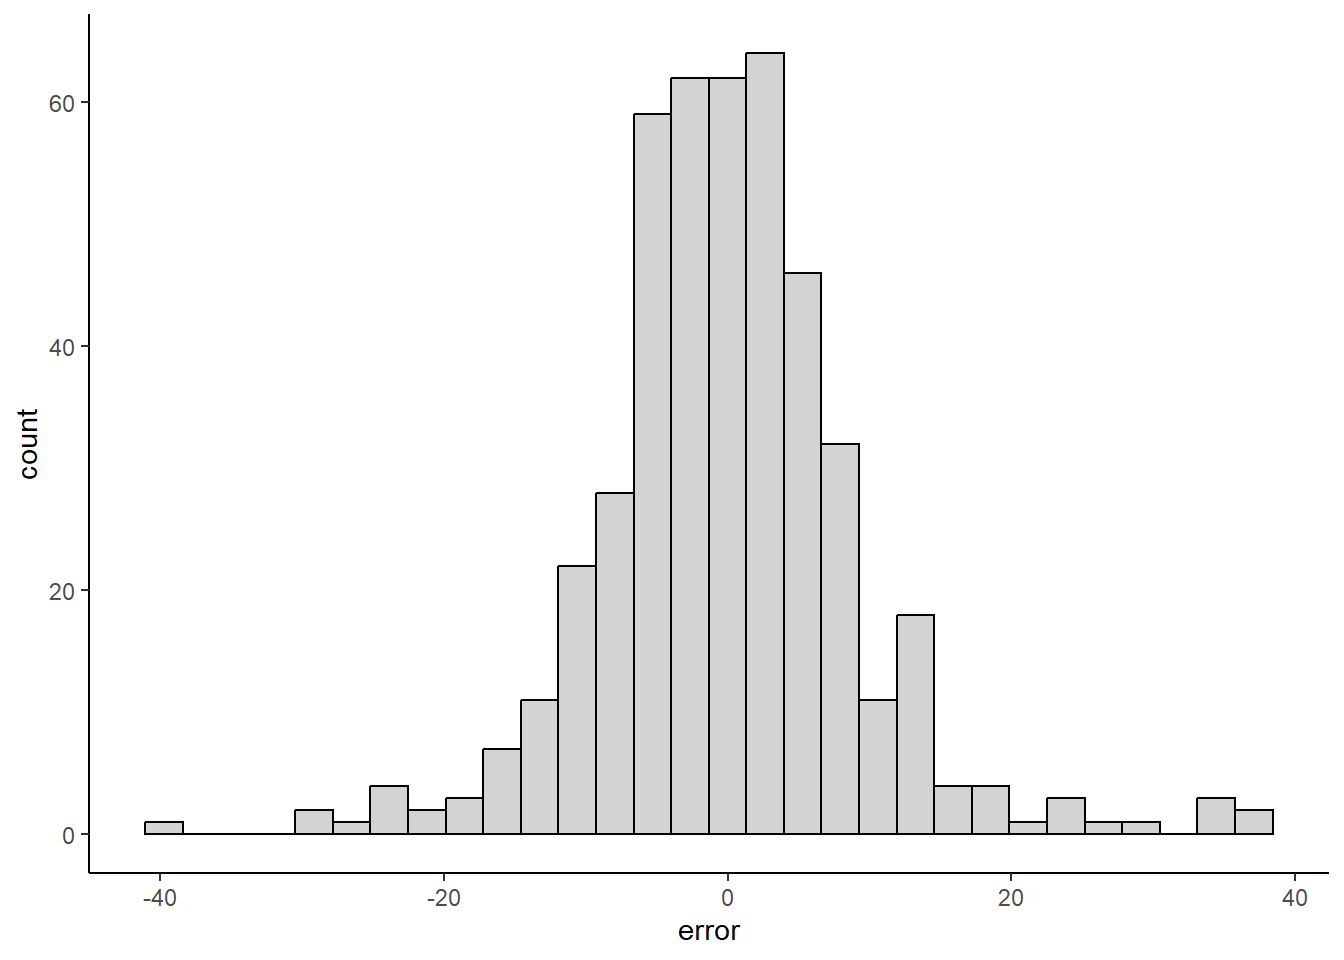

In [ ]:
model_partner_prim <- lmer(oq45_scored ~ time_c*arm_c + oq45_0 + 
                             (1 + time_c | study_id), data = subset(data, dyad == 1))

tibble(error = residuals(model_partner_prim)) |> 
  ggplot(aes(x = error)) +
  geom_histogram(color = "black", fill = "light grey", bins = 30)


##### Look for significant covariates (We will only include covariates that significantly predict the outcome).

`race_white_only` - not significant

In [ ]:
model_partner_prim_race <- lmer(oq45_scored ~ time_c*arm_c + oq45_0 + race_white_only +
                             (1 + time_c | study_id), data = subset(data, dyad == 1))

sjPlot::tab_model(model_partner_prim_race, show.re.var = F, show.icc = F, terms = c("race_white_only"))


oq 45 scored 
 
 
 Predictors 
 Estimates 
 CI 
 p 
 
 
 race white only 
 -1.69 
 -6.98 – 3.60 
 0.531 
 

 
 N study_id 
 170 
 
 Observations 
 454 
 
 
 Marginal R 2 / Conditional R 2 
 0.475 / 0.776

`age_c` - not significant

In [ ]:
model_partner_prim_age <- lmer(oq45_scored ~ time_c*arm_c + oq45_0 + age_c +
                             (1 + time_c | study_id), 
                             data = subset(data, dyad == 1))

sjPlot::tab_model(model_partner_prim_age, show.re.var = F, show.icc = F, terms = c("age_c"))


oq 45 scored 
 
 
 Predictors 
 Estimates 
 CI 
 p 
 
 
 2.What is your age? 
 0.00 
 -0.15 – 0.16 
 0.969 
 

 
 N study_id 
 170 
 
 Observations 
 454 
 
 
 Marginal R 2 / Conditional R 2 
 0.474 / 0.776

`edu_c` - **significant**

In [ ]:
model_partner_prim_edu <- lmer(oq45_scored ~ time_c*arm_c + oq45_0 + edu_c +
                             (1 + time_c | study_id), 
                             data = subset(data, dyad == 1))

sjPlot::tab_model(model_partner_prim_edu, show.re.var = F, show.icc = F, terms = c("edu_c"))


oq 45 scored 
 
 
 Predictors 
 Estimates 
 CI 
 p 
 
 
 edu c 
 -2.46 
 -4.55 – -0.37 
 0.021 
 

 
 N study_id 
 170 
 
 Observations 
 454 
 
 
 Marginal R 2 / Conditional R 2 
 0.486 / 0.777

`meetings_yn` - not significant

In [ ]:
model_partner_prim_meetings <- lmer(oq45_scored ~ time_c*arm_c + oq45_0 + meetings_yn +
                             (1 + time_c | study_id), 
                             data = subset(data, dyad == 1))

sjPlot::tab_model(model_partner_prim_meetings, show.re.var = F, show.icc = F, terms = c("meetings_yn"))


oq 45 scored 
 
 
 Predictors 
 Estimates 
 CI 
 p 
 
 
 meetings yn 
 0.21 
 -4.81 – 5.23 
 0.936 
 

 
 N study_id 
 170 
 
 Observations 
 454 
 
 
 Marginal R 2 / Conditional R 2 
 0.474 / 0.775

`outpatient_yn_ever` - **significant**

In [ ]:
model_partner_prim_outpatient <- lmer(oq45_scored ~ time_c*arm_c + oq45_0 + 
                                       outpatient_yn_ever + (1 + time_c | study_id), 
                                 data = subset(data, dyad == 1))

sjPlot::tab_model(model_partner_prim_outpatient, show.re.var = F, show.icc = F, terms = c("outpatient_yn_ever"))


oq 45 scored 
 
 
 Predictors 
 Estimates 
 CI 
 p 
 
 
 Did they have atleast one outpatient treatment for alcohol or drug use within the surveyed peirod? 
 9.99 
 0.57 – 19.41 
 0.038 
 

 
 N study_id 
 170 
 
 Observations 
 454 
 
 
 Marginal R 2 / Conditional R 2 
 0.482 / 0.776

`er_yn_ever` - Not significant

In [ ]:
model_partner_prim_er <- lmer(oq45_scored ~ time_c*arm_c + oq45_0 + 
                              er_yn_ever + (1 + time_c | study_id), 
                          data = subset(data, dyad == 1))

sjPlot::tab_model(model_partner_prim_er, show.re.var = F, show.icc = F, terms = c("er_yn_ever"))


oq 45 scored 
 
 
 Predictors 
 Estimates 
 CI 
 p 
 
 
 Did they have atleast one ER visit within the surveyed peirod? 
 3.79 
 -2.02 – 9.61 
 0.200 
 

 
 N study_id 
 170 
 
 Observations 
 454 
 
 
 Marginal R 2 / Conditional R 2 
 0.477 / 0.776

`mat_yn` - not significant

In [ ]:
model_partner_prim_mat <- lmer(oq45_scored ~ time_c*arm_c + oq45_0 + 
                              mat_yn + (1 + time_c | study_id), 
                          data = subset(data, dyad == 1))

sjPlot::tab_model(model_partner_prim_mat, show.re.var = F, show.icc = F, terms = c("mat_yn"))


oq 45 scored 
 
 
 Predictors 
 Estimates 
 CI 
 p 
 
 
 mat yn 
 9.22 
 -0.20 – 18.63 
 0.055 
 

 
 N study_id 
 170 
 
 Observations 
 454 
 
 
 Marginal R 2 / Conditional R 2 
 0.479 / 0.778

`inpatient_yn_ever` - not significant

In [ ]:
model_partner_prim_inpatient <- lmer(oq45_scored ~ time_c*arm_c + oq45_0 + 
                              inpatient_yn_ever + (1 + time_c | study_id), 
                          data = subset(data, dyad == 1))

sjPlot::tab_model(model_partner_prim_inpatient, show.re.var = F, show.icc = F, terms = c("inpatient_yn_ever"))


oq 45 scored 
 
 
 Predictors 
 Estimates 
 CI 
 p 
 
 
 Did they have atleast one inpatient treatment for alcohol or drug use within the surveyed peirod? 
 11.49 
 -3.59 – 26.57 
 0.135 
 

 
 N study_id 
 170 
 
 Observations 
 454 
 
 
 Marginal R 2 / Conditional R 2 
 0.478 / 0.776

`other_psych_treatment_yn` - **significant**

In [ ]:
model_partner_prim_psych <- lmer(oq45_scored ~ time_c*arm_c + oq45_0 + 
                              other_psych_treatment_yn + (1 + time_c | study_id), 
                          data = subset(data, dyad == 1))

sjPlot::tab_model(model_partner_prim_psych, show.re.var = F, show.icc = F, terms = c("other_psych_treatment_yn"))


oq 45 scored 
 
 
 Predictors 
 Estimates 
 CI 
 p 
 
 
 other psych treatment yn 
 5.33 
 0.23 – 10.43 
 0.041 
 

 
 N study_id 
 170 
 
 Observations 
 454 
 
 
 Marginal R 2 / Conditional R 2 
 0.481 / 0.770

`other_medications_yn` - **significant**

In [ ]:
model_partner_prim_psych_meds <- lmer(oq45_scored ~ time_c*arm_c + oq45_0 + 
                              other_medications_yn + (1 + time_c | study_id), 
                          data = subset(data, dyad == 1))

sjPlot::tab_model(model_partner_prim_psych_meds, show.re.var = F, show.icc = F, terms = c("other_medications_yn"))


oq 45 scored 
 
 
 Predictors 
 Estimates 
 CI 
 p 
 
 
 6.Did you take any medications to help with other psychological or emotional issues? 
 6.02 
 1.88 – 10.15 
 0.004 
 

 
 N study_id 
 170 
 
 Observations 
 452 
 
 
 Marginal R 2 / Conditional R 2 
 0.491 / 0.769

##### Final Model with Significant Covariates

In [ ]:
model_partner_prim <- lmer(oq45_scored ~ time_c*arm_c + oq45_0 + edu_c +
                             outpatient_yn_ever + other_psych_treatment_yn +
                             other_medications_yn +
                             (1 + time_c | study_id), data = subset(data, dyad == 1))

sjPlot::tab_model(model_partner_prim, show.re.var = F, show.icc = F)


oq 45 scored 
 
 
 Predictors 
 Estimates 
 CI 
 p 
 
 
 (Intercept) 
 54.11 
 51.34 – 56.88 
 <0.001 
 
 
 time c 
 -0.86 
 -2.24 – 0.52 
 0.222 
 
 
 arm_cfam_and_achess_vs_C 
 -2.48 
 -7.07 – 2.10 
 0.287 
 
 
 arm_cachess_vs_fam 
 -1.05 
 -6.26 – 4.17 
 0.693 
 
 
 oq 45 0 
 0.71 
 0.61 – 0.81 
 <0.001 
 
 
 edu c 
 -2.34 
 -4.38 – -0.30 
 0.025 
 
 
 Did they have atleast one outpatient treatment for alcohol or drug use within the surveyed peirod? 
 8.18 
 -0.97 – 17.34 
 0.080 
 
 
 other psych treatment yn 
 3.72 
 -1.43 – 8.87 
 0.156 
 
 
 6.Did you take any medications to help with other psychological or emotional issues? 
 5.35 
 1.18 – 9.53 
 0.012 
 
 
 time_c:arm_cfam_and_achess_vs_C 
 -1.55 
 -4.53 – 1.43 
 0.308 
 
 
 time_c:arm_cachess_vs_fam 
 0.75 
 -2.56 – 4.07 
 0.655 
 

 
 N study_id 
 170 
 
 Observations 
 452 
 
 
 Marginal R 2 / Conditional R 2 
 0.508 / 0.767

#### Secondary Patient Outcome: `per_days_abstinent`

Distribution of residuals  
*Looks fine*

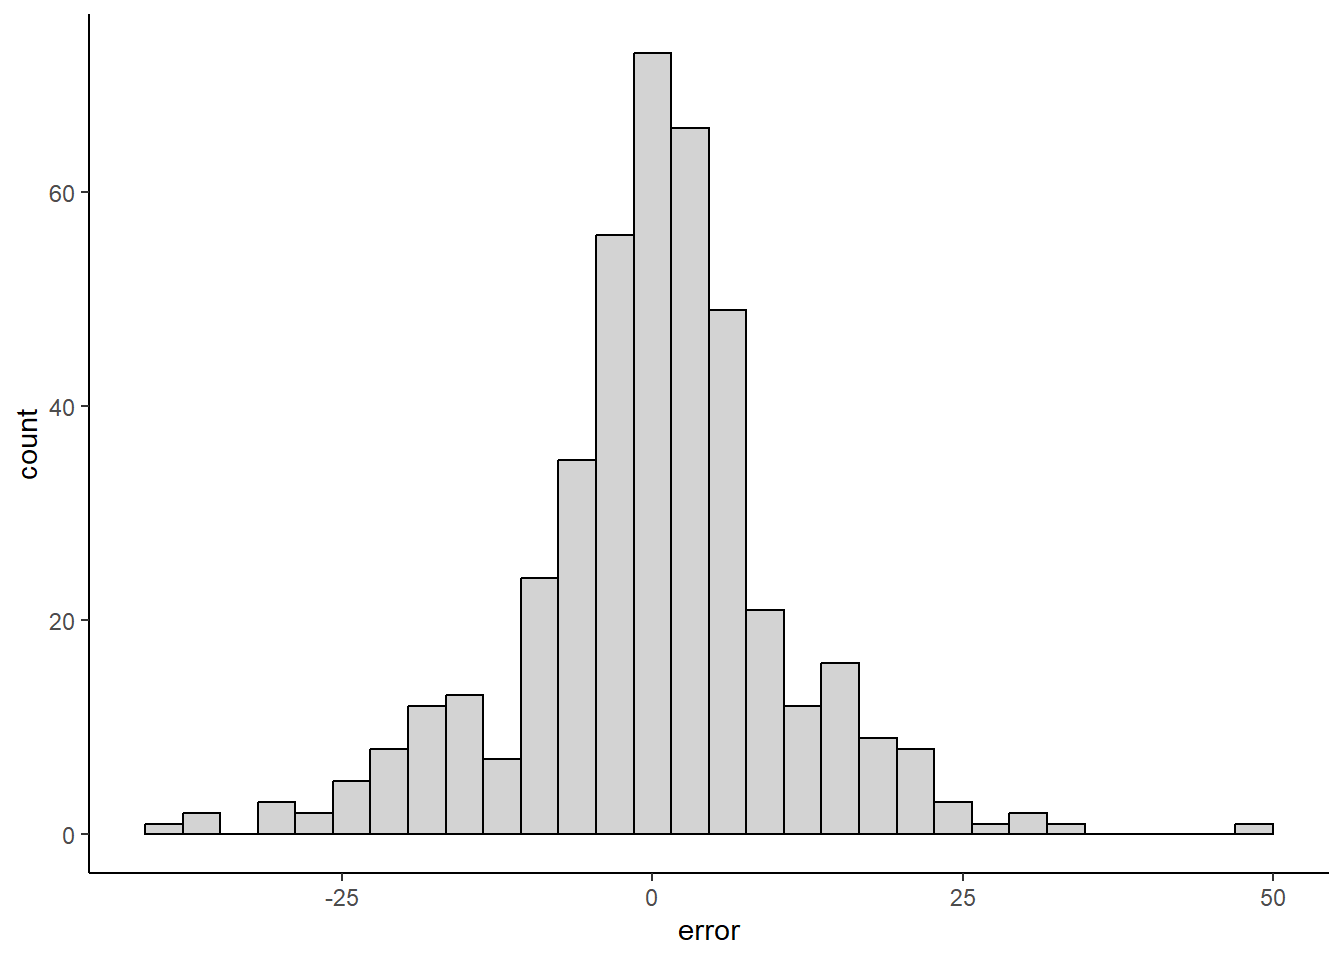

In [ ]:
model_patient_sec <- lmer(per_days_abstinent ~ time_c*arm_c + pda_0 + 
                             (1 + time_c | study_id), data = subset(data, dyad == 2))

tibble(error = residuals(model_patient_sec)) |> 
  ggplot(aes(x = error)) +
  geom_histogram(color = "black", fill = "light grey", bins = 30)


#### Secondary Partner Outcome 1: `relationsatisf_scored`

Distribution of residuals

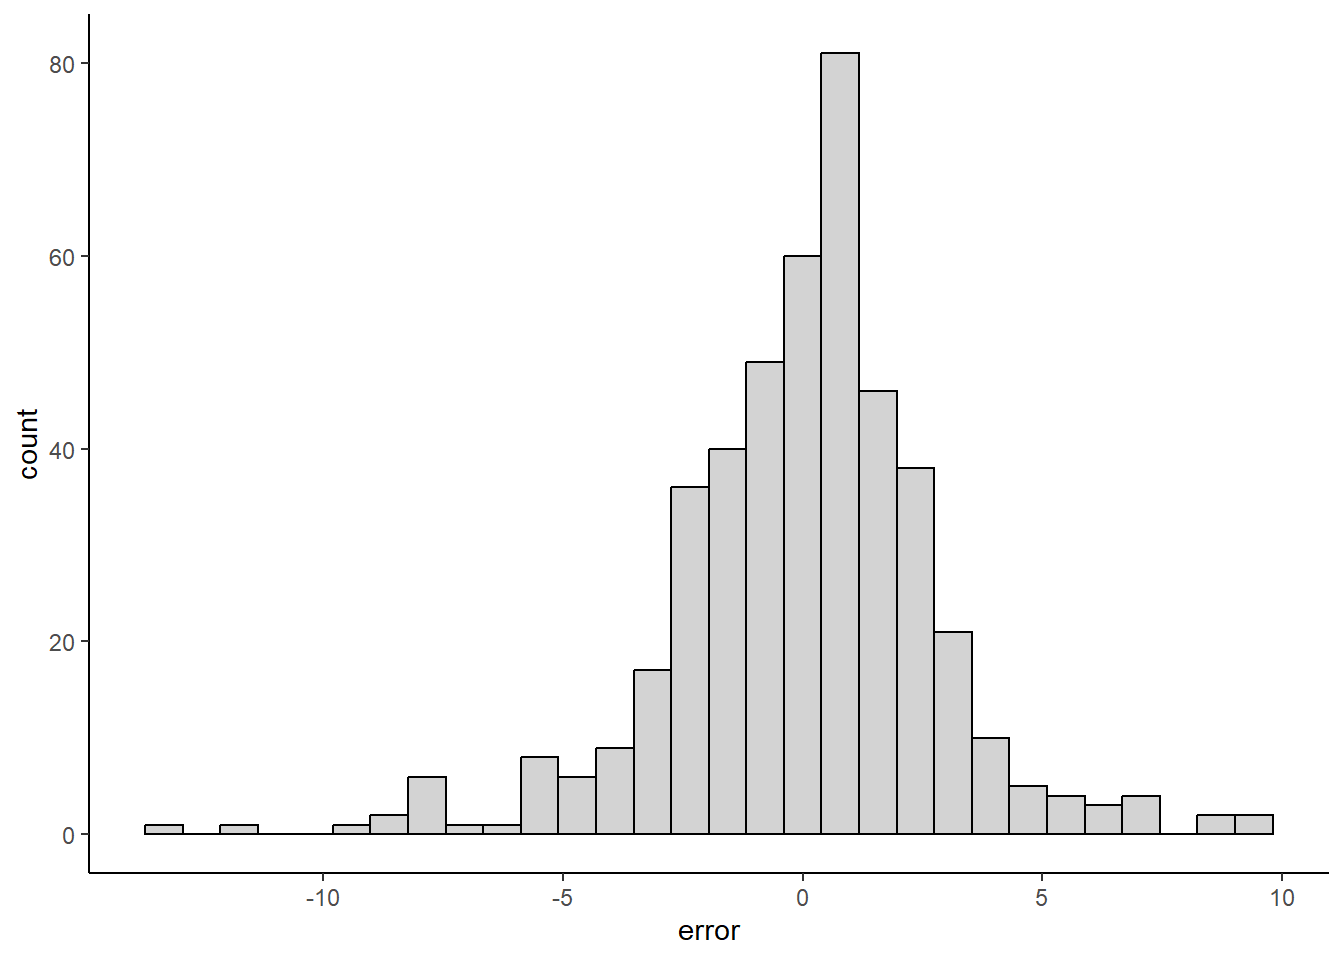

In [ ]:
model_partner_sec_1 <- lmer(relationsatisf_scored ~ time_c*arm_c + relationsatisf_0 + 
                             (1 + time_c | study_id), data = subset(data, dyad == 1))

tibble(error = residuals(model_partner_sec_1)) |> 
  ggplot(aes(x = error)) +
  geom_histogram(color = "black", fill = "light grey", bins = 30)


#### Secondary Partner Outcome 2: `abuse_scored`

Distribution of residuals  
*KW: Look into potential outliers?*

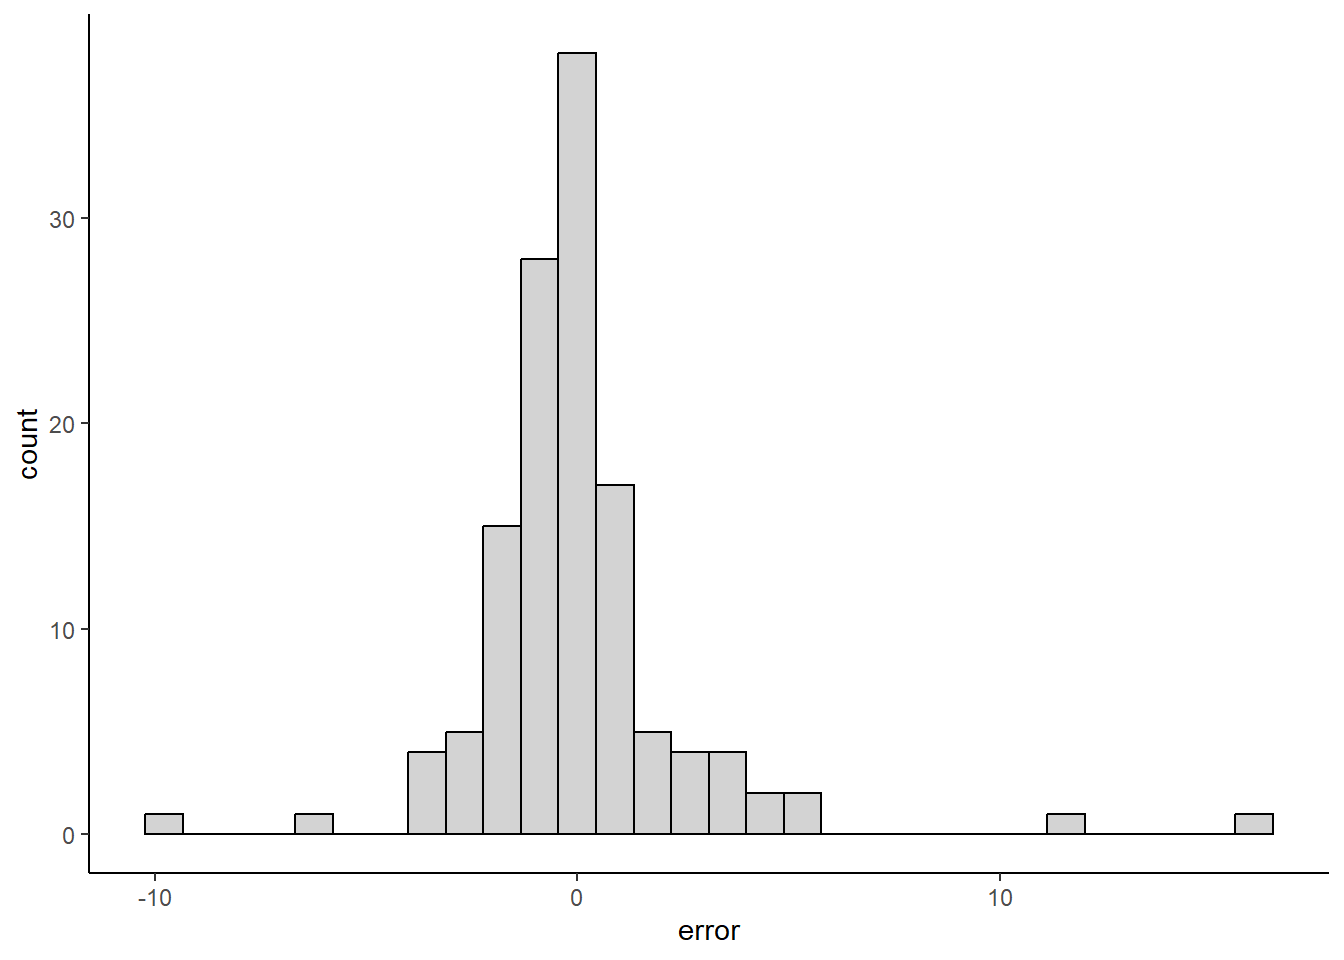

In [ ]:
model_partner_sec_2 <- lmer(abuse_scored ~ time_c*arm_c + abuse_0 +
                             (1 + time_c | study_id), data = subset(data, dyad == 1))

tibble(error = residuals(model_partner_sec_2)) |> 
  ggplot(aes(x = error)) +
  geom_histogram(color = "black", fill = "light grey", bins = 30)


### Check Assumptions for Analyses of Mediators

**KW: mediators only for primary outcomes**

List of mediators:

### Check Assumptions for Analyses of Moderators

**KW: moderators only for primary outcomes**

List of moderators:

### Save out processed data for analyses

In [ ]:
data |> 
  write_csv(here::here(path_data, "famchess_data_ana.csv"))
